In [39]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.primitives import Sampler
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

In [40]:
def compute_ring_radius(p,q):
    a = np.pi/p
    b = np.pi/q
    r0 = np.sqrt(np.cos(a+b)/np.cos(a-b))
    return r0

def hyperbolic_distance(kappa, z1, z2):
    d = kappa * np.arccosh(1 + (2 * (abs(z1 - z2))**2 / ((1 - abs(z1)**2) * (1 - abs(z2)**2))))
    return d

def unit_cell_positions(p,q):
    r0 = compute_ring_radius(p,q)
    vertices_positions = []
    for k in range(p):
        vertices_positions.append(r0 * np.exp(1j * np.pi * (2*k-1) / p))
    
    d0 = 0.66
    for k in range(p):
        vertices_positions.append(d0 * np.exp(1j * np.pi * (2*k-1) / p))
    
    return vertices_positions

def inner_ring_coords(p,q):
    vertices_positions = unit_cell_positions(p,q)
    vertices_coords = []
    for k in range(len(vertices_positions)):
        x,y = vertices_positions[k].real, vertices_positions[k].imag
        vertices_coords.append(np.array([x,y]))
    return vertices_coords

def euclidean_distance(z1, z2):
    d = abs(z1 - z2)
    return d

def rotation_matrix(phi):
    return np.array([[np.exp(1j*phi/2), 0], [0, np.exp(-1j*phi/2)]])

def Fuchsian_generators(p_B, q_B):
    alpha = 2* np.pi/ p_B
    beta = 2* np.pi/ q_B
    sigma = np.sqrt((np.cos(alpha) + np.cos(beta)) / (1 + np.cos(beta)) )
    gamma1 = 1/(np.sqrt(1-sigma**2)) * np.array([[1, sigma], [sigma,1]])
    FG_generators = []
    for mu in range(0,int(p_B/2)):
        FG_generators.append(rotation_matrix(mu*alpha) @ gamma1 @ rotation_matrix(-mu*alpha))
    for j in range(int(p_B/2)):
        FG_generators.append(np.linalg.inv(FG_generators[j]))
    return FG_generators 

def create_new_vertex(vertex_position, translation_matrix):
    v = translation_matrix @ np.array([vertex_position, 1])
    new_vertex_position = v[0]/v[1]
    return new_vertex_position

def plot_vertices_with_edges(vertices):
    vertex_to_edges = {}
    edge_to_vertices = {}
    d0 = hyperbolic_distance(kappa, vertices[0], vertices[1])
    coords = [(v.real, v.imag) for v in vertices]
  
    G = nx.Graph()
    for idx, pos in enumerate(coords):
        G.add_node(idx, pos=pos, label=True)
        
    edge_count = 0  # Counter for edge labels
    
    for i, pos1 in enumerate(vertices):
        for j, pos2 in enumerate(vertices[i+1:], start=i+1):
            if hyperbolic_distance(kappa, pos1, pos2) < (d0 + 0.1):
                G.add_edge(i, j, with_labels=True)
                vertex_to_edges[(i, j)] = edge_count
                edge_to_vertices[edge_count] = (i,j)
                edge_count += 1            

    pos_dict = {idx: pos for idx, pos in enumerate(coords)}
    
    # Set figure size
    plt.figure(figsize=(20, 20))  # Adjust the width and height as needed
    
    # Draw the graph
    nx.draw(
        G,
        pos=pos_dict,
        node_size=50,  # Adjust node size
        node_color="lightblue",
        with_labels=True,
        font_size=12,  # Increase font size for node labels
        font_color="black"
    )
    
    # Draw edge labels
    nx.draw_networkx_edge_labels(
        G,
        pos=pos_dict,
        edge_labels=vertex_to_edges,
        font_size=10,  # Increase font size for edge labels
        label_pos=0.5,  # Adjust edge label position (closer to the center of edges)
    )
    
    plt.axis("equal")  # Ensure equal scaling
    plt.show()  # Display the plot
    
    return G, vertex_to_edges, edge_to_vertices

def get_edge_labels_for_vertex(G, vertex, vertex_to_edges):
    # Get all edges incident to the given vertex
    incident_edges = list(G.edges(vertex))
    
    # Retrieve the labels for these edges from the vertex_to_edges dictionary
    incident_edge_labels = {edge: vertex_to_edges[tuple(sorted(edge))] for edge in incident_edges}

    
    return incident_edge_labels.values()

In [41]:
twelve_face_connections = {72: [109],
73: [94, 108],
74: [93, 143],
75: [120, 142],
76: [153, 127],
77: [152],
186: [31],
187: [30, 40],
188: [121, 47],
189: [120, 138],
190: [91, 137],
191: [90, 108],
184: [107, 61],
185: [60],
78: [171],
79: [170],
89: [174],
90: [173],
153: [30],
154: [29, 47],
155: [46, 56],
156: [105, 63],
157: [104, 122],
158: [121, 139],
159: [138],
92: [25],
93: [24],
94: [59],
95: [44, 58],
88: [43],
106: [175],
107: [174],
109: [58],
110: [43, 57],
111: [28, 42],
104: [27],
123: [168],
124: [175, 57],
125: [42, 56],
126: [27, 41],
127: [26],
140: [41],
141: [26, 40],
142: [25],
143: [60],
136: [173, 59],
137: [172],
168: [45],
169: [44, 62],
170: [61]}

#TODO Double check the correction of these connections
one_face_connections = {
    8: [12,13],
    9: [12,13],
    10: [14, 15],
    11: [14, 15],
}

In [42]:
p = 8
q = 3

p_B = 8
q_B = 8
kappa = 1

unit_cell = unit_cell_positions(p,q)
Bolza_generators = Fuchsian_generators(p_B, q_B)
outer_ring = []

for generator in Bolza_generators+[Bolza_generators[4]@ Bolza_generators[3], Bolza_generators[0]@ Bolza_generators[7], Bolza_generators[3]@ Bolza_generators[5]]:
    for vertex in unit_cell:
        new_vertex = create_new_vertex(vertex, generator)
        
    # Check if new_vertex is not in any of the vertices in D
        if all(hyperbolic_distance(1,new_vertex,vertex)> 0.01 for vertex in unit_cell+outer_ring):
            outer_ring.append(new_vertex)



final_vertices = unit_cell + outer_ring


def add_periodicity_edges(graph, connections, vertex_to_edges, edge_to_vertices):
    edge_count = len(graph.edges())

    for source, targets in connections.items():
        for target in targets:
            graph.add_edge(source, target, with_labels=True)
            vertex_to_edges[tuple(sorted((source, target)))] = edge_count
            edge_to_vertices[edge_count] = tuple(sorted((source,target)))
            edge_count += 1
    
    coords = [(v.real, v.imag) for v in final_vertices]
    pos_dict = {idx: pos for idx, pos in enumerate(coords)}

    nx.draw(
        graph,
        pos=pos_dict,
        node_size=50,  # Adjust node size
        node_color="lightblue",
        with_labels=True,
        font_size=12,  # Increase font size for node labels
        font_color="black"
    )
    nx.draw_networkx_edge_labels(
        graph,
        pos=pos_dict,
        edge_labels=vertex_to_edges,
        font_size=10,  # Increase font size for edge labels
        label_pos=0.5,  # Adjust edge label position (closer to the center of edges)
    )
    return graph






In [43]:
def generate_circuit(graph, err_prob, vertex_to_edges):
    affected_edges = []
    num_vertices = len(graph.nodes())
    num_edges = len(graph.edges())
    
    vertices_qubits = QuantumRegister(num_vertices, 'vertices_qubits')
    edges_qubits = QuantumRegister(num_edges, 'edges_qubits')
    # print(num_edges)
    # print(num_vertices)
    cr = ClassicalRegister(num_vertices, 'cr')
    # We will still add classical registers for plaquettes
    qc = QuantumCircuit()
    qc.add_register(vertices_qubits)
    qc.add_register(edges_qubits)
    qc.add_register(cr)

    for j in range(len(edges_qubits)):
        random_number = np.random.rand()
        if random_number < err_prob:
            qc.x(edges_qubits[j])
            affected_edges.append(j)
            
    # for j in err_prob:
    #     qc.x(edges_qubits[j])
    #     affected_edges.append(j)
    # print('affected_edges', affected_edges)

    
    for v in range(len(graph.nodes())):
        incident_edges = get_edge_labels_for_vertex(graph, v, vertex_to_edges)
        for edge in incident_edges:
            # qc.h(edges_qubits[edge])
            # qc.cx(edges_qubits[edge], vertices_qubits[v])
            # qc.h(edges_qubits[edge])
            # edges_qubits[edge]
            qc.cx(edges_qubits[edge], vertices_qubits[v])

        qc.barrier()
        
    for v in range(len(graph.nodes())):
        qc.measure(vertices_qubits[v], cr[v])
    
    
        
    # qubits_of_interest = [edges_qubits[5], vertices_qubits[2], vertices_qubits[3], edges_qubits[149], vertices_qubits[130], vertices_qubits[131]]

    # filtered_circuit = QuantumCircuit(*qubits_of_interest, cr[0], cr[1])
    
    # # Copy only the instructions that involve the selected qubits
    # for instruction in qc.data:
    #     qubits, clbits = instruction[1], instruction[2]
    #     if any(q in qubits_of_interest for q in qubits):
    #         filtered_circuit.append(instruction[0], qubits, clbits)
    # 
    # # Draw the filtered circuit
    # filtered_circuit.draw("mpl")
    
    return qc, affected_edges

In [44]:
def generate_syndrome_graph(indices, graph):
    syndrome_graph = nx.Graph()
    for v in indices:
        syndrome_graph.add_node(v, label = True)

    for i, ver1 in enumerate(indices):
        for j, ver2 in enumerate(indices[i+1:], start=i+1):
            weight = nx.shortest_path_length(graph, source=ver1, target=ver2)
            syndrome_graph.add_edge(ver1, ver2, weight=weight)

    # Draw the syndrome graph
    pos = nx.spring_layout(syndrome_graph)  # Positioning for better visualization
    # nx.draw(syndrome_graph, pos, with_labels=True, node_color="lightblue", node_size=500)

    # Add edge labels showing the weights
    edge_labels_with_weight = nx.get_edge_attributes(syndrome_graph, 'weight')  # Retrieve weights
    # nx.draw_networkx_edge_labels(syndrome_graph, pos, edge_labels=edge_labels_with_weight)

    # Show the graph
    # plt.show()
    return syndrome_graph

In [45]:
def find_correction_paths(syndrome_graph, circuit_graph):
    matching = nx.algorithms.matching.min_weight_matching(syndrome_graph)

    correction_paths = []
    # Print the matching
    # print("Minimum Weight Perfect Matching:", matching)
    for edge in matching:
        # print(edge, "with weight", syndrome_graph.edges[edge]['weight'])
        path = nx.shortest_path(circuit_graph, source=edge[0], target=edge[1])
        # print('path', path)
        correction_paths.append(path)
    return correction_paths
        


In [46]:
def get_edge_from_v1_v2(v1,v2, vertex_to_edges):
    tup = tuple(sorted((v1, v2)))
    return vertex_to_edges[tup]

def find_all_plaquette_edges(original_graph, vertex_to_edges):
    plaquettes = nx.minimum_cycle_basis(original_graph)
    all_plaquette_edges = []
    for plaquette_vertices in plaquettes:
        plaquette_edges = []
        i = 0
        for v in plaquette_vertices:
            # print(plaquette_vertices)
            plaquette_edges.append(get_edge_from_v1_v2(plaquette_vertices[i], plaquette_vertices[(i+1)%p], vertex_to_edges))
            i = i+1
        
        # all_plaquette_edges.append((plaquette_vertices, plaquette_edges))
    return all_plaquette_edges
            
# for k,v in all_plaquette_edges:
#     print(k,v)

In [47]:
# if the syndrome measurement plus the affected errors span two neighboring, then the function will detect a logic error while there is none

# print('affected_edges', sorted(affected_edges))
def get_logical_error(affected_edges, correction_paths, all_plaquette_edges, vertex_to_edges):
    affected_edges_set = set(affected_edges)
    all_correction_edges = set()
    for correction_path in correction_paths:
        for i in range(len(correction_path)-1):
            all_correction_edges.add(get_edge_from_v1_v2(correction_path[i],correction_path[i+1], vertex_to_edges))
    # print('correction_edg', sorted(all_correction_edges))
    
    if all_correction_edges == affected_edges_set: 
        return False

    # remove the common edges between affected and correction edges
    intersection = all_correction_edges.intersection(affected_edges_set)
    union = all_correction_edges.union(affected_edges_set)
    potential_plaquettes = union - intersection
    
    # print('potential_plaquettes', potential_plaquettes)
    # if something remains, check if they form plaquettes by looping over the 17 possible plaquettes
    if len(potential_plaquettes) % p != 0:
        return True
    
    for _,v in all_plaquette_edges:
        if set(v).issubset(potential_plaquettes):
            potential_plaquettes -= set(v)
    if len(potential_plaquettes) > 0:
        return True
    return False

# print(get_logical_error())
            

In [50]:
def error_graph(graph, original_graph, vertex_to_edges): 
    trials = 1000
    error_probabilities = [0.05*j for j in range(11)]
    error_percentages = []
    for ep in error_probabilities:
        count = 0
        for i in range(trials):
            qcc, affected_edges = generate_circuit(graph, ep, vertex_to_edges)
            simulator = AerSimulator()
            result = simulator.run(qcc, shots=1).result().get_counts()
            syndrome_measurement = next(iter(result))[::-1]
            indices= [j for j, bit in enumerate(syndrome_measurement) if bit == "1"]
            # print('affected_edges', sorted(affected_edges))
            
            syndrome_graph = generate_syndrome_graph(indices, graph)
            correction_paths = find_correction_paths(syndrome_graph, graph)
            all_plaquette_edges = find_all_plaquette_edges(original_graph, vertex_to_edges)
            is_err = get_logical_error(affected_edges, correction_paths, all_plaquette_edges, vertex_to_edges)
            if is_err:
                count += 1
        error_percentages.append(count/trials)
    
    return error_percentages
        
    
    
        
        
    # print("detected error above ^\n")
    # print('edge_to_vertices', edge_to_vertices)
    # print(f"number of logical errors using the {8,3} code {count} out of {trials} trials")


    
    

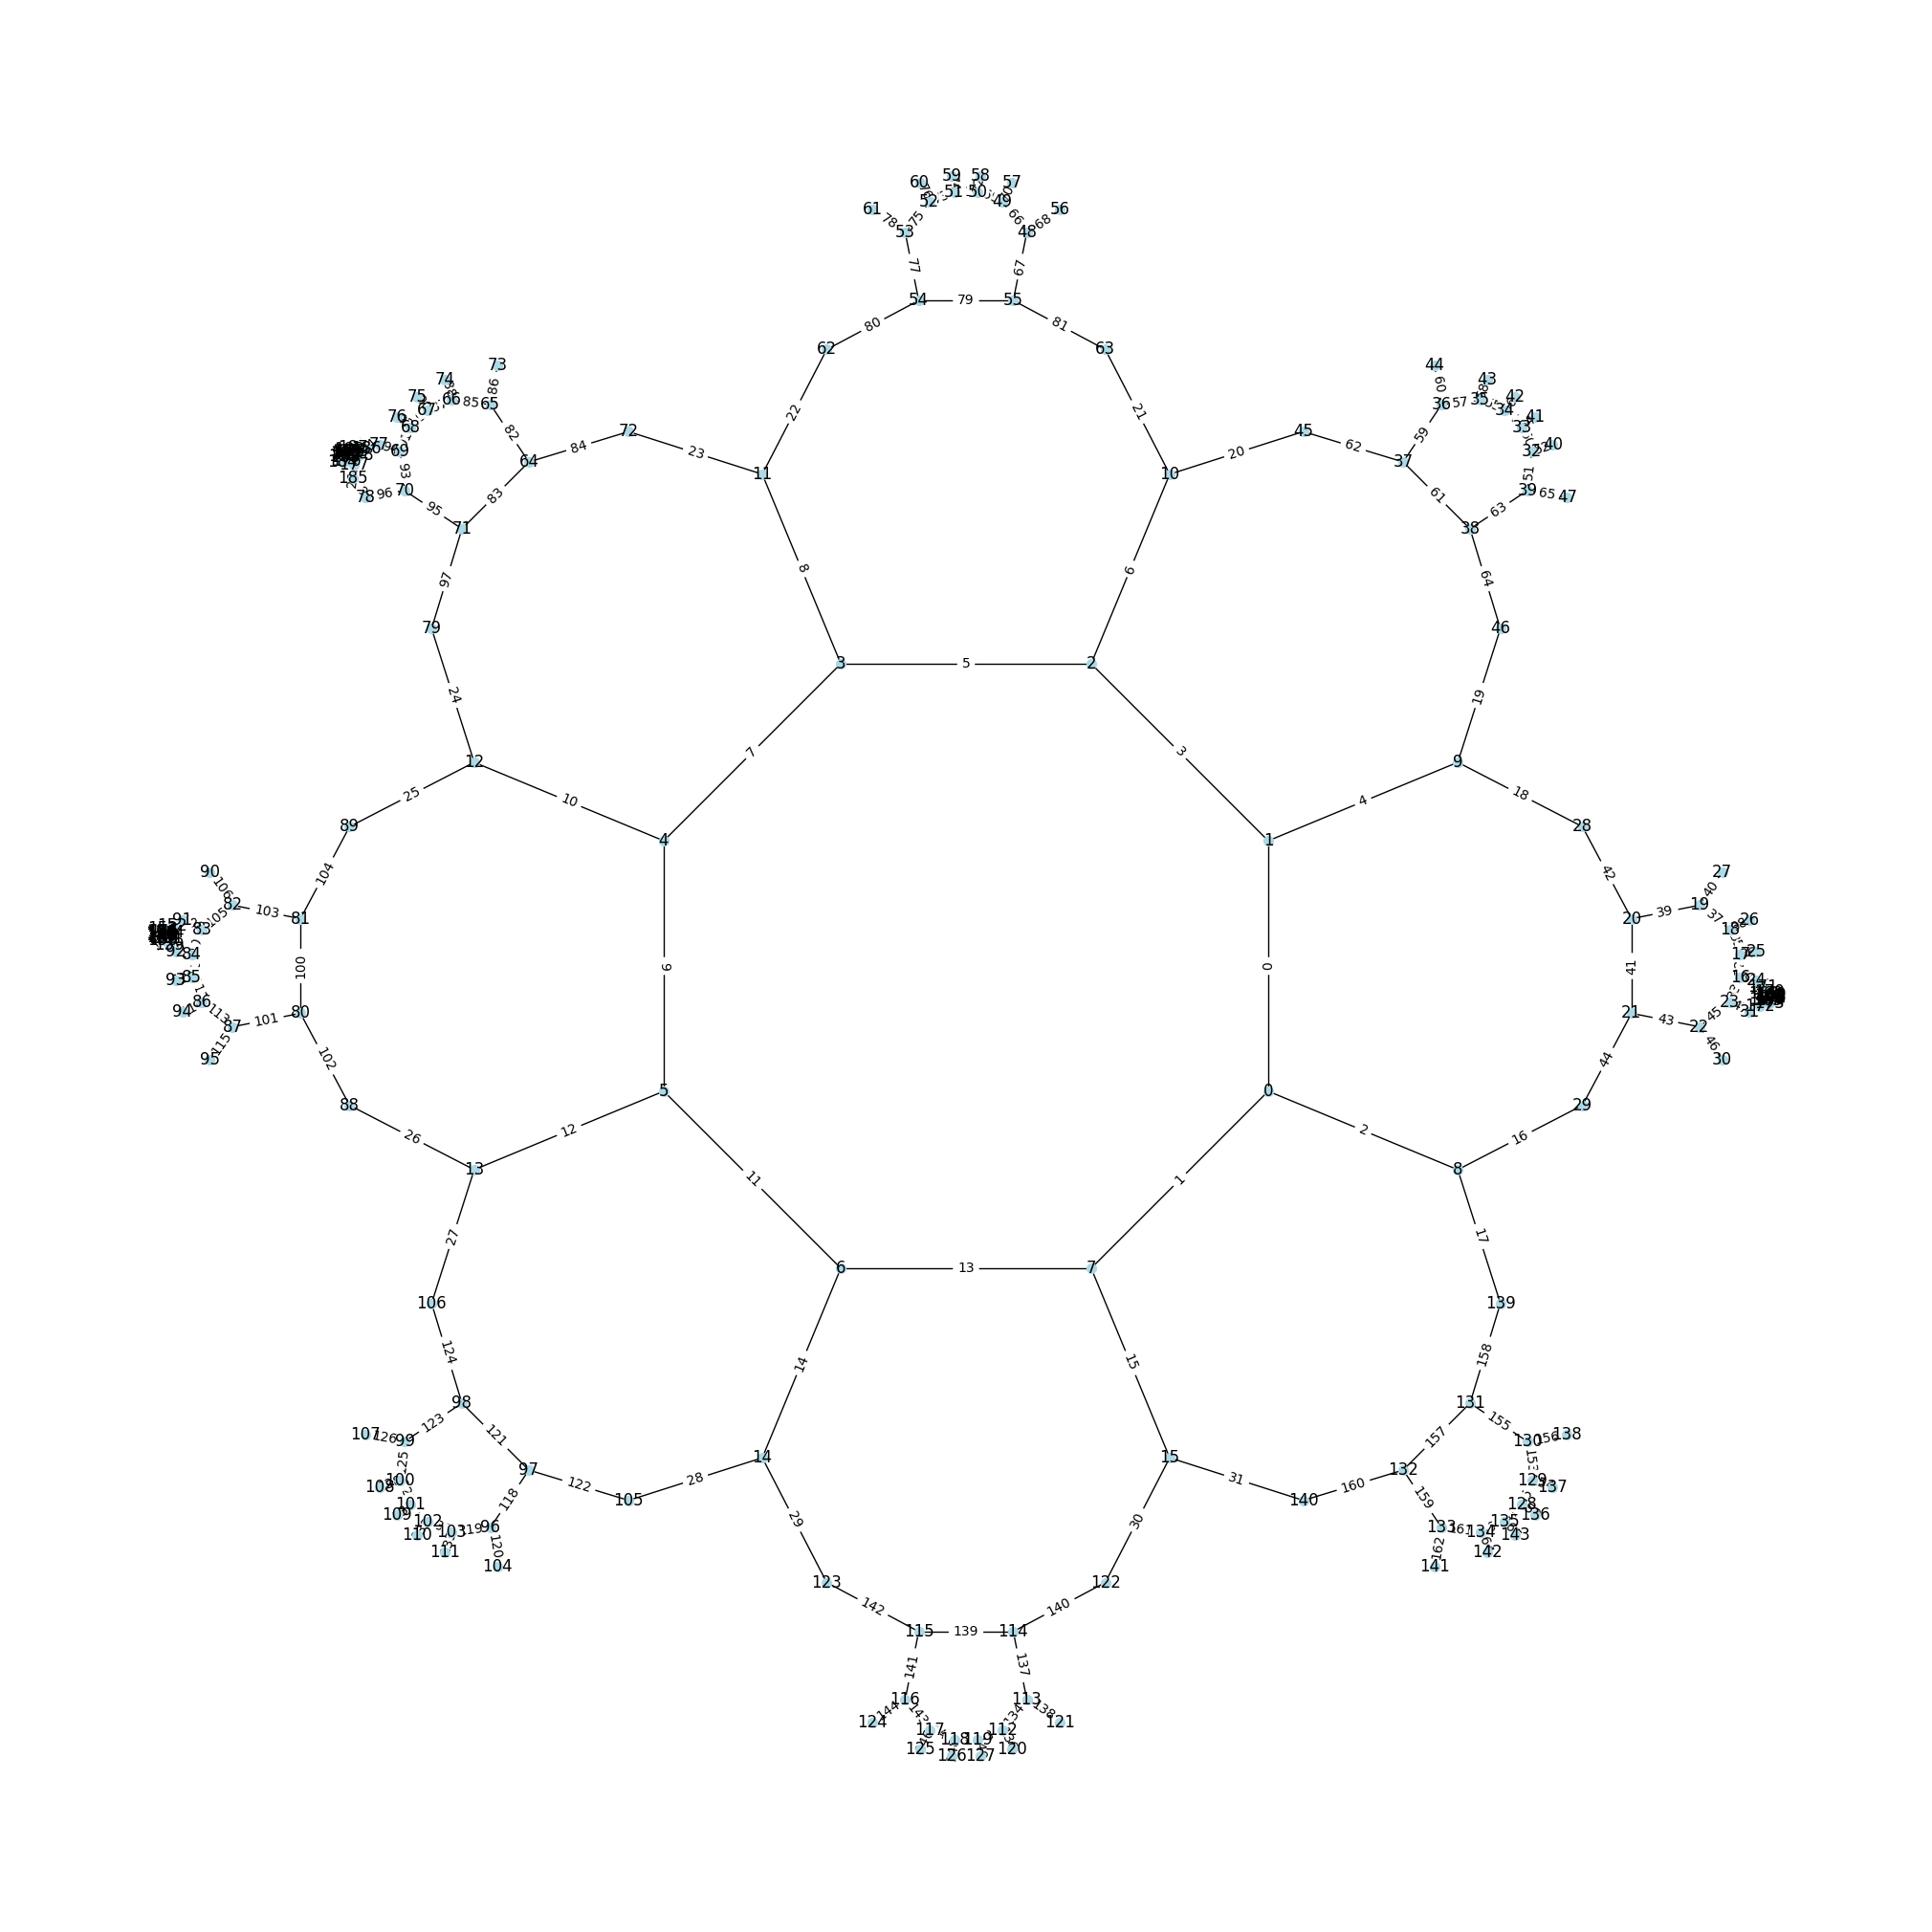

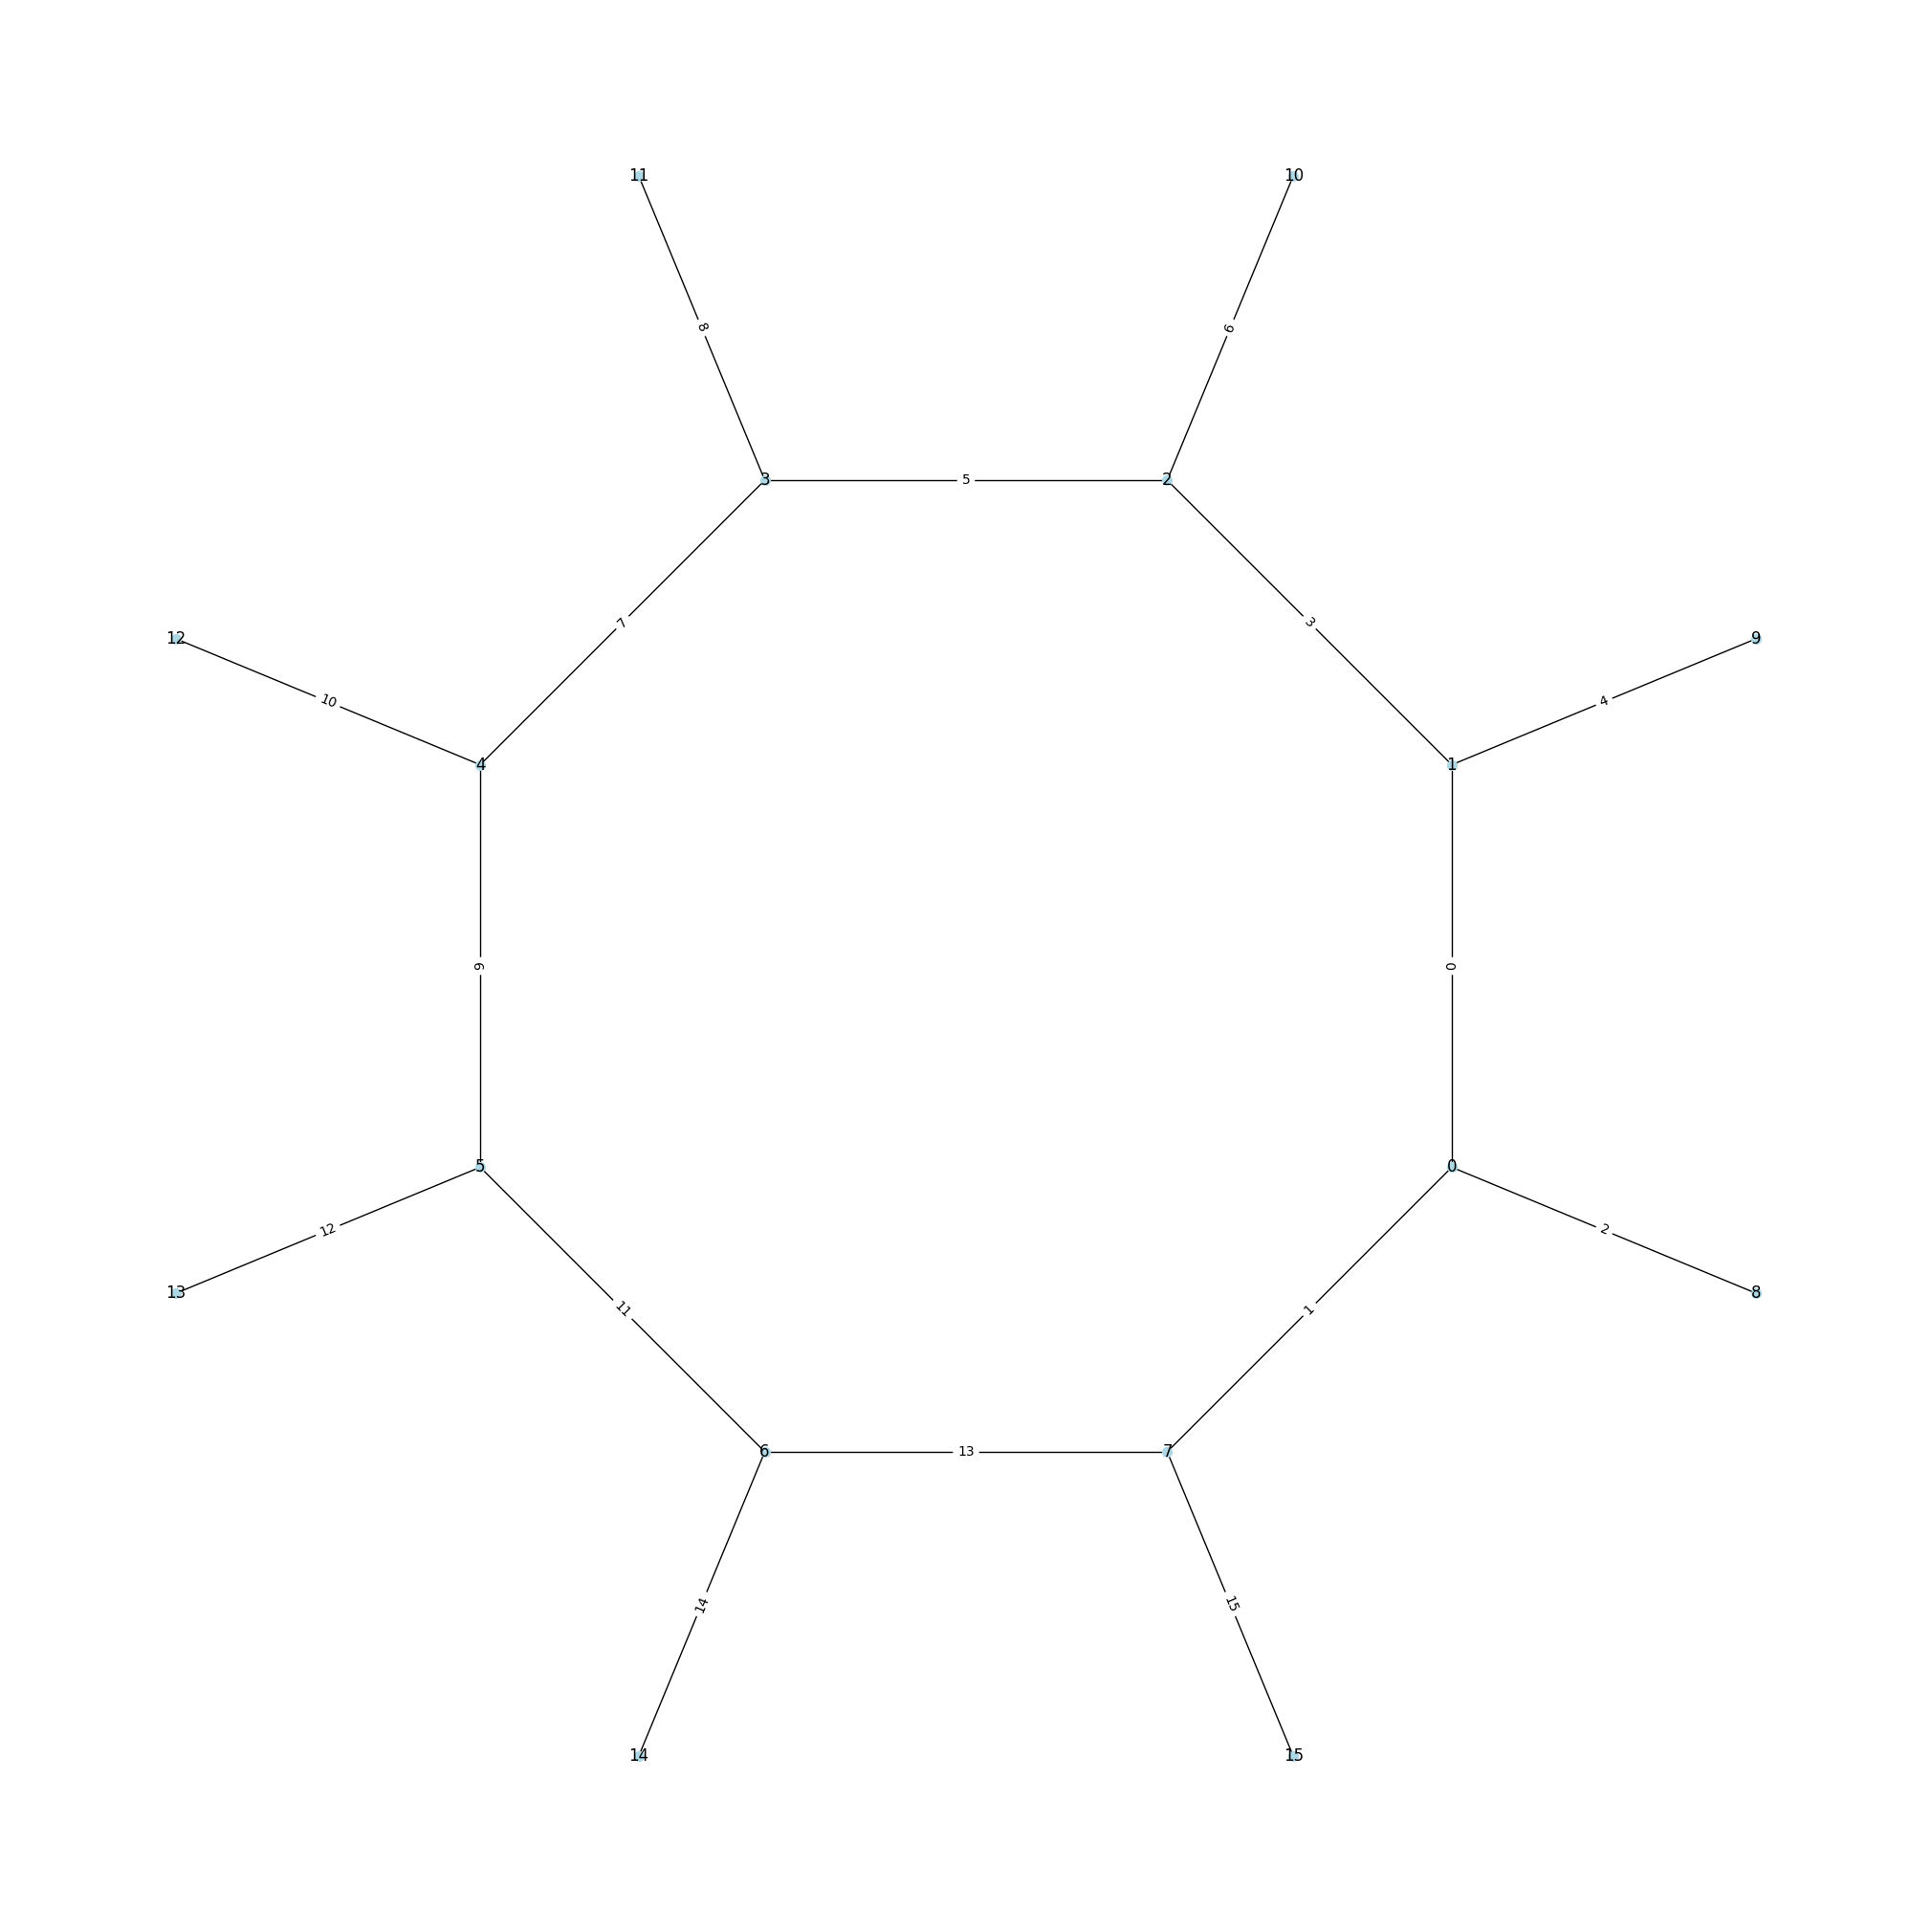

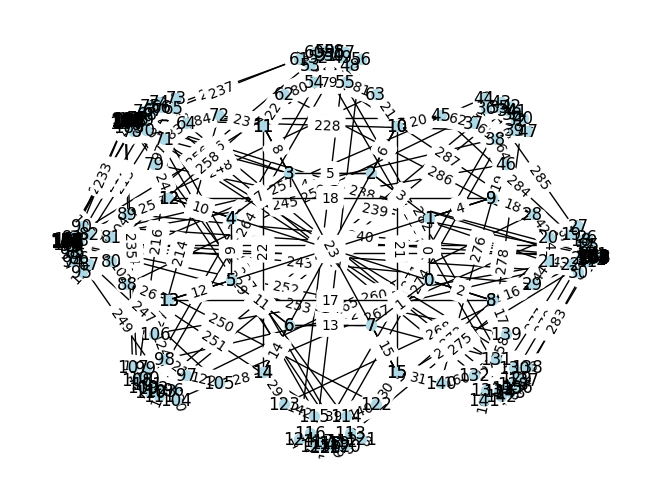

In [52]:
# error_graph(twelver_circuit_graph, twelve_face_original_graph)
twelve_face_graph, twelve_vertex_to_edges, twelve_edge_to_vertices = plot_vertices_with_edges(final_vertices)
one_face_graph, one_vertex_to_edges, one_edge_to_vertices = plot_vertices_with_edges(unit_cell)

twelve_face_original_graph = copy.deepcopy(twelve_face_graph)
one_face_original_graph = copy.deepcopy(one_face_graph)

twelver_circuit_graph = add_periodicity_edges(twelve_face_graph, twelve_face_connections, twelve_vertex_to_edges, twelve_edge_to_vertices)
one_circuit_graph = add_periodicity_edges(one_face_graph, one_face_connections, one_vertex_to_edges, one_edge_to_vertices)

one_err_percentage = error_graph(one_circuit_graph, one_face_original_graph, one_vertex_to_edges)
twelve_err_percentage = error_graph(twelver_circuit_graph, twelve_face_original_graph,  twelve_vertex_to_edges) 




In [53]:
twe_face_num_qubits = twelver_circuit_graph.number_of_edges()
one_face_num_qubits = one_circuit_graph.number_of_edges()

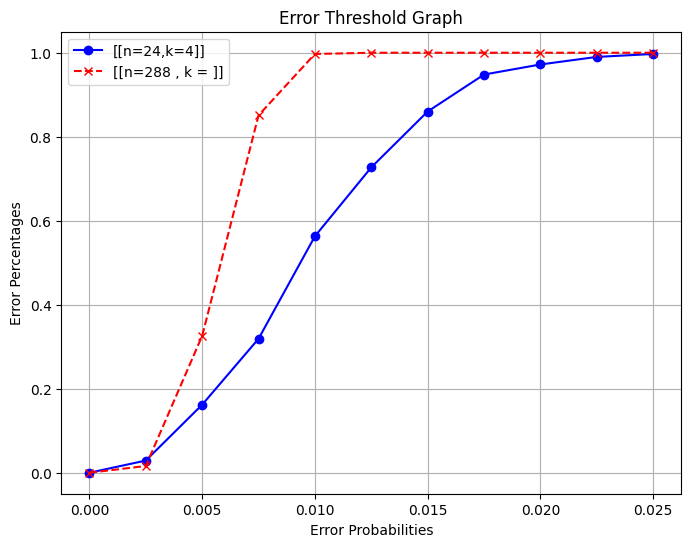

In [57]:
plt.figure(figsize=(8, 6))  # Set the figure size
error_probabilities = [0.0025*j for j in range(11)]
plt.plot(error_probabilities, one_err_percentage, marker='o', linestyle='-', color='b', label=f'[[n={one_face_num_qubits},k=4]]')
plt.plot(error_probabilities, twelve_err_percentage, label=f'[[n={twe_face_num_qubits} , k = ]]', color="red", linestyle="--", marker="x")

# Add labels and a title
plt.xlabel('Error Probabilities')
plt.ylabel('Error Percentages')
plt.title('Error Threshold Graph')
plt.legend()

# Show the grid and the graph
plt.grid(True)
plt.show()